# Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from itertools import product

# Setting Options

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')
# return an output value upto 3 decimals
pd.options.display.float_format = '{:.3f}'.format
sns.set_style("whitegrid")

# Loading Email Spam Dataset

In [3]:
df=pd.read_csv('spam.csv',encoding='latin-1')
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


# Cleaning Data

In [4]:
# Dropping the last 3 columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
df.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [5]:
# Renaming the columns
df.rename(columns={'v1': 'Target', 'v2': 'Email'}, inplace=True)
df.head(10)

,Target,Email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
# Mapping the target labels to 0 for ham and 1 for spam
df['Target']=df['Target'].map({'ham': 0, 'spam': 1})
df.head(10)

,Target,Email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


# Exploratory Data Analysis

In [7]:
# Size of the data
data_size = df.shape[0]

# Proportion of spam
spam_proportion = df['Target'].value_counts(normalize=True)[1]

# Proportion of ham
ham_proportion = df['Target'].value_counts(normalize=True)[0]

print(f"Size of the data: {data_size}")
print(f"Proportion of spam: {spam_proportion:.2%}")
print(f"Proportion of ham: {ham_proportion:.2%}")


Size of the data: 5572
Proportion of spam: 13.41%
Proportion of ham: 86.59%


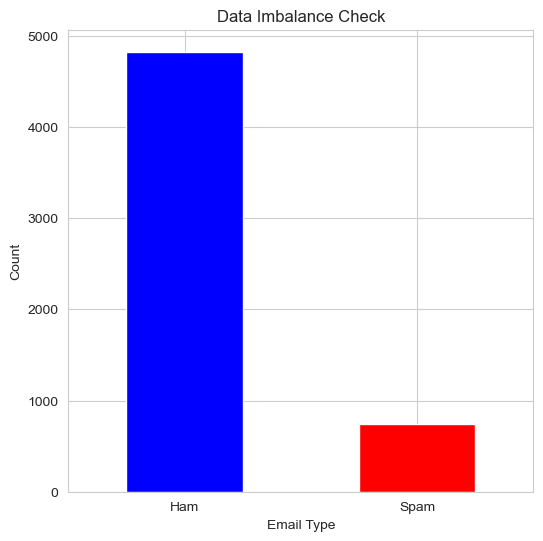

In [8]:
# Data Imbalance Check
plt.figure(figsize=(6, 6))
df['Target'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xticks([0, 1], ['Ham', 'Spam'], rotation=0)
plt.title('Data Imbalance Check')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

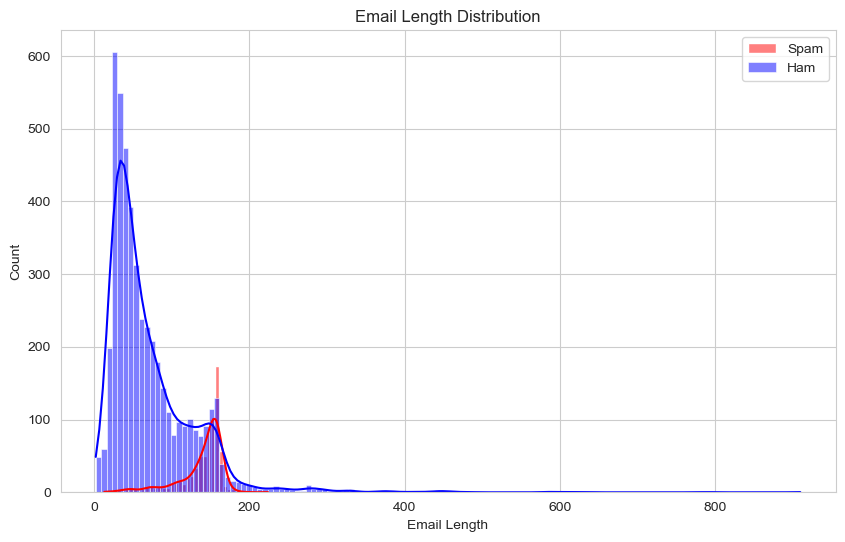

In [9]:
# Email Length Analysis
df['Email_Length'] = df['Email'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df[df['Target'] == 1]['Email_Length'], color='red', label='Spam', kde=True)
sns.histplot(df[df['Target'] == 0]['Email_Length'], color='blue', label='Ham', kde=True)
plt.legend()
plt.title('Email Length Distribution')
plt.xlabel('Email Length')
plt.show()

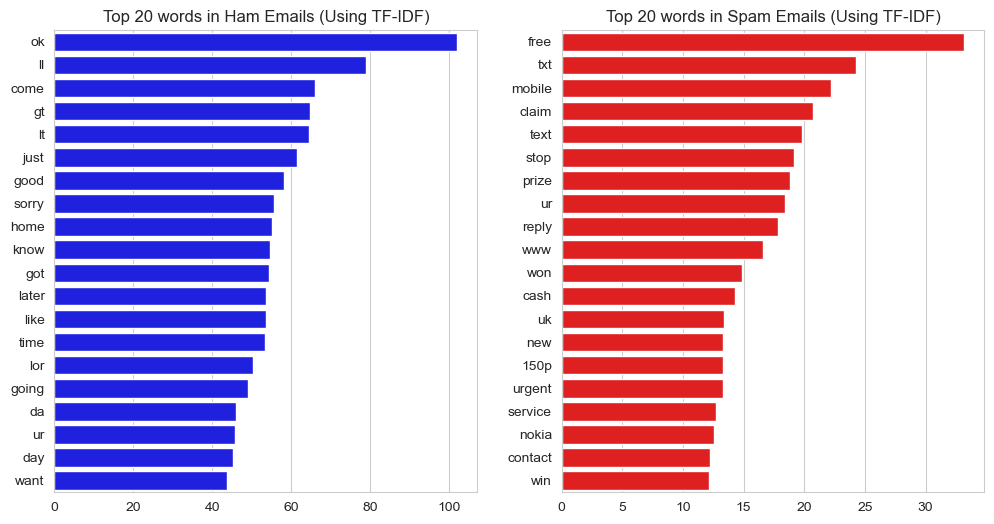

In [10]:
spam_data = df[df['Target'] == 1]
ham_data = df[df['Target'] == 0]

# Create TfidfVectorizer with English stopwords
tfidf = TfidfVectorizer(stop_words='english')

# Combine the text data for both spam and ham
combined_data = df['Email']

# Fit and transform the combined data
tfidf_matrix = tfidf.fit_transform(combined_data)

# Get the feature names (words) from the TfidfVectorizer
feature_names = tfidf.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Get the TF-IDF scores for spam and ham
spam_tfidf_df = tfidf_df[df['Target'] == 1]
ham_tfidf_df = tfidf_df[df['Target'] == 0]

# Get the sum of TF-IDF scores for each word in spam and ham emails
spam_word_scores = spam_tfidf_df.sum()
ham_word_scores = ham_tfidf_df.sum()

# Get top 20 words for spam and ham emails
top_spam_words = spam_word_scores.nlargest(20)
top_ham_words = ham_word_scores.nlargest(20)

# Plotting word frequency using TF-IDF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=top_ham_words, y=top_ham_words.index, color='blue')
plt.title('Top 20 words in Ham Emails (Using TF-IDF)')
plt.subplot(1, 2, 2)
sns.barplot(x=top_spam_words, y=top_spam_words.index, color='red')
plt.title('Top 20 words in Spam Emails (Using TF-IDF)')
plt.show()

Interesting to see that in spam, the length of email is a concise 1-200 worded email and in ham, it has more variance in length. Also, the top 20 words excluding stop words, the words in the spam emails contain more words like "free", "stop", "reply", "claim", "won" etc.

# Further Text Preprocessing

In [11]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

# Splitting the Data

In [12]:
X_train, X_valid, y_train, y_valid= train_test_split(df['Email'], df['Target'], test_size=0.3, random_state=0)
print(X_train.head())
print(X_valid.head())

4380               Mathews or tait or edwards or anderson
3887                   ok....take care.umma to you too...
4755    Don't make life too stressfull.. Always find t...
2707    Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...
4747    The beauty of life is in next second.. which h...
Name: Email, dtype: object
4456    Aight should I just plan to come up later toni...
690                                    Was the farm open?
944     I sent my scores to sophas and i had to do sec...
3768    Was gr8 to see that message. So when r u leavi...
1189    In that case I guess I'll see you at campus lodge
Name: Email, dtype: object


Since only 13.41% of the data is spam, instead of a 80/20 train/test split, we will use 70/30 train/test split. 

In [13]:
X_train.isnull().any()

False

In [14]:
# Apply the preprocessing function to the 'Email' column
X_train = X_train.apply(preprocess_text)
X_valid = X_valid.apply(preprocess_text)

In [15]:
print(X_train.head())
print(X_valid.head())

4380               mathews or tait or edwards or anderson
3887                           oktake careumma to you too
4755    dont make life too stressfull always find time...
2707    great new offer double mins double txt on best...
4747    the beauty of life is in next second which hid...
Name: Email, dtype: object
4456    aight should i just plan to come up later tonight
690                                     was the farm open
944     i sent my scores to sophas and i had to do sec...
3768    was gr8 to see that message so when r u leavin...
1189     in that case i guess ill see you at campus lodge
Name: Email, dtype: object


In [16]:
# Removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

In [17]:
# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix_train = tfidf.fit_transform(X_train)
tfidf_matrix_valid= tfidf.transform(X_valid)

tfidf_matrix_train.shape

(3900, 7433)

In [18]:
def my_confusion_matrix(y_test, y_pred, plt_title, accuracy_title):
    cm=confusion_matrix(y_test, y_pred)
    print(f'{accuracy_title} Accuracy Score:', '{:.2%}'.format(accuracy_score(y_valid, y_pred)))
    print(classification_report(y_test, y_pred))
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='magma')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(plt_title)
    plt.show()
    return cm

# Logistic Regression

In [19]:
log_reg_classifier=LogisticRegression(solver='liblinear')
log_reg_classifier.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_log=log_reg_classifier.predict(tfidf_matrix_valid)

Logistic Regression: Accuracy Score: 94.56%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1434
           1       0.98      0.63      0.77       238

    accuracy                           0.95      1672
   macro avg       0.96      0.81      0.87      1672
weighted avg       0.95      0.95      0.94      1672



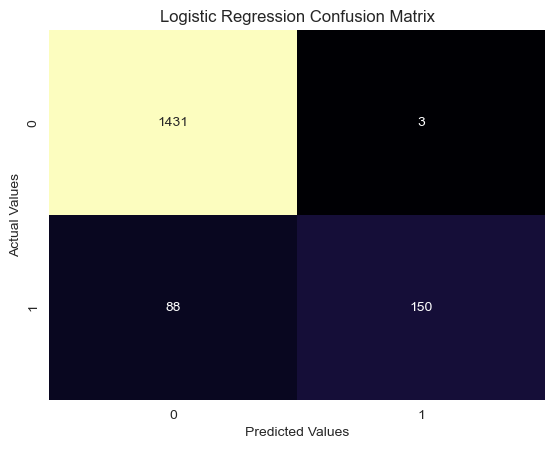

array([[1431,    3],
       [  88,  150]], dtype=int64)

In [20]:
my_confusion_matrix(y_valid, y_pred_log, 'Logistic Regression Confusion Matrix', 'Logistic Regression:')

# Naive Bayes

In [21]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_nb = nb_classifier.predict(tfidf_matrix_valid)

Naive Bayes: Accuracy Score: 95.69%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1434
           1       1.00      0.70      0.82       238

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672



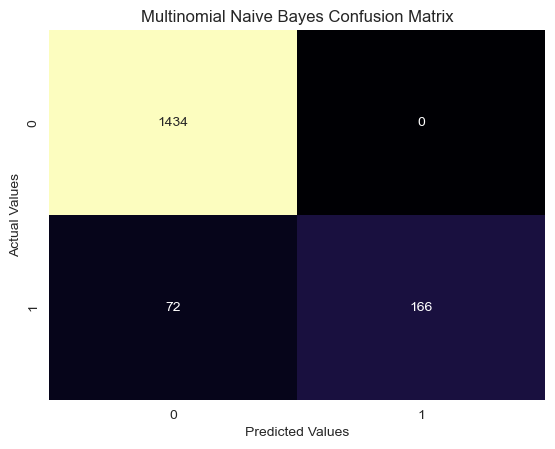

array([[1434,    0],
       [  72,  166]], dtype=int64)

In [22]:
my_confusion_matrix(y_valid, y_pred_nb, 'Multinomial Naive Bayes Confusion Matrix', 'Naive Bayes:')

# Support Vector Machines

### Linear Kernel

In [23]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_lin_svm = svm_classifier.predict(tfidf_matrix_valid)

Support Vector Machine - Linear: Accuracy Score: 97.91%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1434
           1       0.98      0.87      0.92       238

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



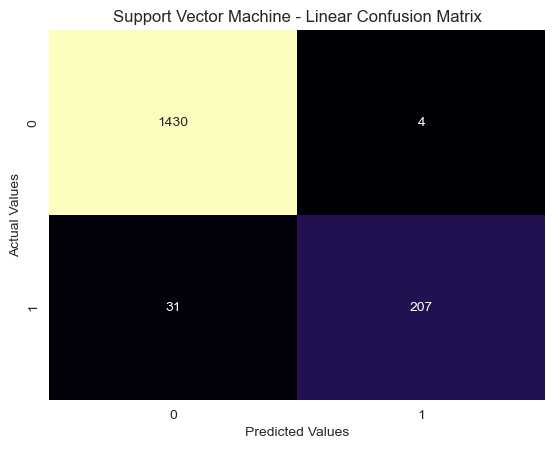

array([[1430,    4],
       [  31,  207]], dtype=int64)

In [24]:
my_confusion_matrix(y_valid, y_pred_lin_svm, 'Support Vector Machine - Linear Confusion Matrix', 'Support Vector Machine - Linear:')

### Polynomial Kernel Degree 3

In [25]:
svm_classifier_poly = SVC(kernel='poly', degree=3, gamma='scale', coef0=0.0)
svm_classifier_poly.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_poly_svm = svm_classifier_poly.predict(tfidf_matrix_valid)

Support Vector Machine - Polynomial(3): Accuracy Score: 92.46%
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1434
           1       1.00      0.47      0.64       238

    accuracy                           0.92      1672
   macro avg       0.96      0.74      0.80      1672
weighted avg       0.93      0.92      0.91      1672



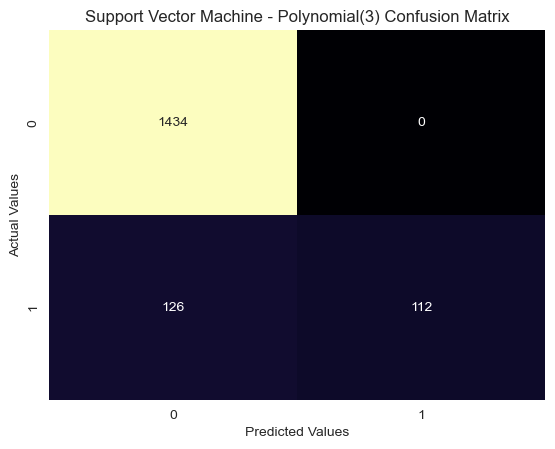

array([[1434,    0],
       [ 126,  112]], dtype=int64)

In [26]:
my_confusion_matrix(y_valid, y_pred_poly_svm, 'Support Vector Machine - Polynomial(3) Confusion Matrix', 'Support Vector Machine - Polynomial(3):')

### Radial Basis Function Kernel

In [27]:
svm_classifier_rbf = SVC(kernel='rbf', gamma='scale')
svm_classifier_rbf.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_rbf_svm = svm_classifier_rbf.predict(tfidf_matrix_valid)

Support Vector Machine - Radial Basis Function: Accuracy Score: 96.95%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1434
           1       0.99      0.79      0.88       238

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672



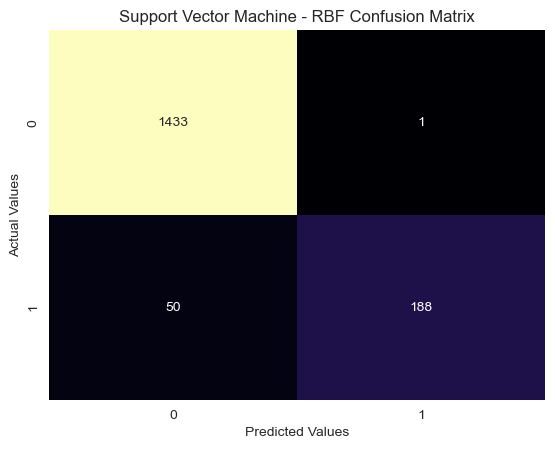

array([[1433,    1],
       [  50,  188]], dtype=int64)

In [28]:
my_confusion_matrix(y_valid, y_pred_rbf_svm, 'Support Vector Machine - RBF Confusion Matrix', 'Support Vector Machine - Radial Basis Function:')

In [29]:
svm_classifier_sigmoid = SVC(kernel='sigmoid', gamma='scale', coef0=0.0)
svm_classifier_sigmoid.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_sigmoid_svm = svm_classifier_sigmoid.predict(tfidf_matrix_valid)

Support Vector Machine - Sigmoid: Accuracy Score: 97.85%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1434
           1       0.98      0.87      0.92       238

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



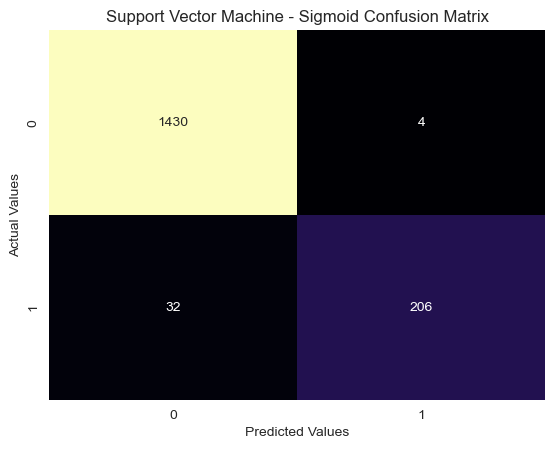

array([[1430,    4],
       [  32,  206]], dtype=int64)

In [30]:
my_confusion_matrix(y_valid, y_pred_sigmoid_svm, 'Support Vector Machine - Sigmoid Confusion Matrix', 'Support Vector Machine - Sigmoid:')

It is important to prioritize reducing false positives to ensure that important messages are not incorrectly classified as spam. Therefore, we are looking at a model with high precision while maintaining a reasonable level of recall. *Note, spam was 1 and ham is 0.*

In this context for SVM, the one with the linear kernel performs **"best"**.

# Multilayer Perceptron Classifier

In [31]:
#Here are the default parameters for MLP:
# MLPClassifier(activation='relu', 
#               alpha=0.0001, 
#               batch_size='auto', 
#               beta_1=0.9, 
#               beta_2=0.999, 
#               early_stopping=False, 
#               epsilon=1e-08, 
#               hidden_layer_sizes=(100,), 
#               learning_rate='constant', 
#               learning_rate_init=0.001, 
#               max_fun=15000, 
#               max_iter=200, 
#               momentum=0.9, 
#               n_iter_no_change=10, 
#               nesterovs_momentum=True, 
#               power_t=0.5, 
#               random_state=None, 
#               shuffle=True, 
#               solver='adam', 
#               tol=0.0001, 
#               validation_fraction=0.1, 
#               verbose=False, 
#               warm_start=False)

In [32]:
mlp=MLPClassifier()
mlp.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_mlp=mlp.predict(tfidf_matrix_valid)

Multiplayer Perceptron Classifier: Accuracy Score: 98.39%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1434
           1       1.00      0.89      0.94       238

    accuracy                           0.98      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672



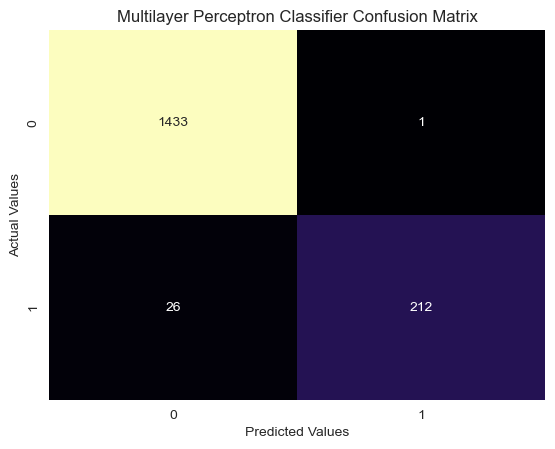

array([[1433,    1],
       [  26,  212]], dtype=int64)

In [33]:
my_confusion_matrix(y_valid, y_pred_mlp, 'Multilayer Perceptron Classifier Confusion Matrix', 'Multiplayer Perceptron Classifier:')

The Multilayer Perceptron Classifier took the longest to run but had the best overall accuracy of 98.68%. Support Vector Machine with a Linear kernel comes a close second at 98.56% but, the time was much faster. If speed is a concern, the SVM Linear kernel is the *best* model, but if not then MLP is the *best* model for this. 

# Hypertuning Our Best Model - Multilayer Perceptron Classifier

In [34]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 300],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'early_stopping': [True]  # Include early_stopping in the parameter grid
}

# Create the GridSearchCV instance with 5-fold cross-validation
mlp_grid = GridSearchCV(MLPClassifier(verbose=True),
                        param_grid,
                        cv=3,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=1)  # Set verbose to 1

# Fit the GridSearchCV instance
mlp_grid.fit(tfidf_matrix_train, y_train)

# Retrieve the best parameters and best estimator
best_params = mlp_grid.best_params_
best_mlp = mlp_grid.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Iteration 1, loss = 0.35271064
Validation score: 0.974359
Iteration 2, loss = 0.06173579
Validation score: 0.982051
Iteration 3, loss = 0.02891108
Validation score: 0.984615
Iteration 4, loss = 0.01938963
Validation score: 0.984615
Iteration 5, loss = 0.01489272
Validation score: 0.982051
Iteration 6, loss = 0.01201048
Validation score: 0.982051
Iteration 7, loss = 0.01028520
Validation score: 0.982051
Iteration 8, loss = 0.00903450
Validation score: 0.982051
Iteration 9, loss = 0.00812994
Validation score: 0.982051
Iteration 10, loss = 0.00734139
Validation score: 0.982051
Iteration 11, loss = 0.00675789
Validation score: 0.982051
Iteration 12, loss = 0.00625328
Validation score: 0.982051
Iteration 13, loss = 0.00594628
Validation score: 0.982051
Iteration 14, loss = 0.00559800
Validation score: 0.982051
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Best Parameters: {'activa

In [35]:
# Build MLP classifier using the best parameters
best_mlp = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    alpha=best_params['alpha'],
    learning_rate=best_params['learning_rate'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=best_params['max_iter'],
    random_state=42
)

# Fit the best MLP classifier on the training data
best_mlp.fit(tfidf_matrix_train, y_train)

# Predict the labels for the validation set
y_pred_best_mlp = best_mlp.predict(tfidf_matrix_valid)

Hypertuned Multiplayer Perceptron Classifier: Accuracy Score: 97.43%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1434
           1       0.94      0.87      0.91       238

    accuracy                           0.97      1672
   macro avg       0.96      0.93      0.95      1672
weighted avg       0.97      0.97      0.97      1672



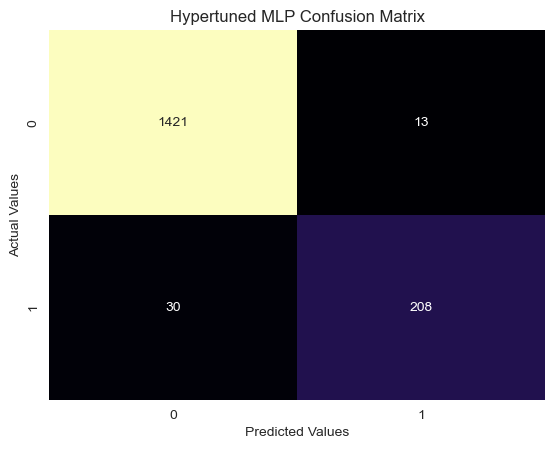

array([[1421,   13],
       [  30,  208]], dtype=int64)

In [36]:
my_confusion_matrix(y_valid, y_pred_best_mlp, 'Hypertuned MLP Confusion Matrix', 'Hypertuned Multiplayer Perceptron Classifier:')

As you can see, with our model that performed best in the validation set, hypertuned using GridSearchCV our results show that the best model has the following parameters: {'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 300, 'solver': 'adam'}. This is close to the default model except the max_iter and hidden layer sizes are different. 

The hypertuned model has  following accuracy score: 97.43% which is less than the default MLP Classifier model.This could be because of overfitting in cross validation, randomness, or the hyperparameter search space was not an optimal set.